<a href="https://colab.research.google.com/github/fahadrafiq94/Machine-Learning/blob/main/09_SkimLit_milestone_project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-7ece112e-937e-dd8b-5263-148b89040a11)


## Get Data
PUGMED 200K Dataset :https://github.com/Franck-Dernoncourt/pubmed-rct

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
# check what files are in pubmed 20k dataset 
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


Dev is another word for validation set 

In [ ]:
# start our experiment using 20k dataset
data_dir  ="/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
# check all the filenames in the target directory 
import os 
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess data

In [ ]:
# cerate a function to read the lines of a document
def get_lines(filename):
  """
  Read filename and return the lines as a list

  Args: 
    filname: string containing the filepath

  Returns:
    A list of strings with one string per line from the target filename.
    """
  with open(filename , "r") as f:
    return f.readlines()

In [ ]:
train_lines  = get_lines(data_dir + "train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
len(train_lines)

210040

lets think about how we want our data to look... 

In [ ]:
def preprocess_text_with_line_numbers (filename):
  input_lines = get_lines(filename)# get all the lines in list format
  abstract_lines = ""  # create an empty abstract
  abstract_samples = [] #create an empty list of abstracts

  # loop through each line in the target file
  for line in input_lines:
    if line.startswith("###"): # check to see if the line is an id line
      abstract_id = line 
      abstract_lines ="" #reset the abstract string if the line is an id line

    elif line.isspace(): #check to see of the line is a new line
      abstract_line_split = abstract_lines.splitlines() # split each line in the abstract

      # iterate thorugh each line in a single and count them at the same time
      for abstract_line_number , abstract_line in enumerate(abstract_line_split):
        line_data = {} # create an empty dictionary
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() #get target text and turn it into lower case
        line_data["line_number"] = abstract_line_number # what line number does the line appear in abstract
        line_data["total_lines"] =len(abstract_line_split) - 1 # how many total lines are there in the target abstract
        abstract_samples.append(line_data)

    else:
      abstract_lines +=line
    
  return abstract_samples

In [ ]:
%%time 
train_sample = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_sample = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_sample = preprocess_text_with_line_numbers(data_dir + "test.txt")

print(len(train_sample) , len(val_sample) , len(test_sample))

180040 30212 30135
CPU times: user 589 ms, sys: 124 ms, total: 712 ms
Wall time: 712 ms


In [ ]:
train_sample[:14]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

In [ ]:
import pandas as pd

In [ ]:
train_df = pd.DataFrame(train_sample)
val_df = pd.DataFrame(val_sample)
test_df = pd.DataFrame(test_sample)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
# distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

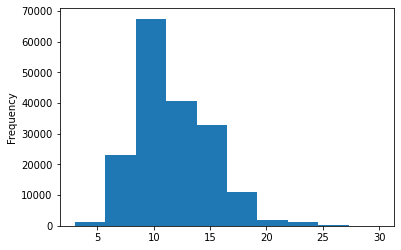

In [ ]:
# len of different lines 
train_df.total_lines.plot.hist();

## Get list of sentences

In [ ]:
# convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences) , len(val_sentences) , len(test_sentences)

(180040, 30212, 30135)

In [ ]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make Numeric Labels 

In [ ]:
# one hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot   =one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

## Label encode Labels

In [ ]:
# extract labels and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded  = label_encoder.transform(test_df["target"].to_numpy())
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# Get Class names and number of classes from label encoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes , class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Model 0: BaseLine 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0=  Pipeline([
      ("tf-idf" , TfidfVectorizer()),
      ("clf" , MultinomialNB())                  
])
model_0.fit(train_sentences,
               train_labels_encoded)

Pipeline(memory=None,
         steps=[('tf-idf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [ ]:
# Evaluate the baseline model
model_0.score(val_sentences,
              val_labels_encoded)

0.7218323844829869

In [ ]:
# Make a prediction using baseline model 
baseline_preds = model_0.predict(val_sentences)
baseline_preds 

array([4, 1, 3, ..., 4, 4, 1])

Getting Helper Functions

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-09-27 03:17:38--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-09-27 03:17:38 (47.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results

In [ ]:
baseline_results = calculate_results(y_true = val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Model 1:Conv1D using Token embedding 

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
 # How long is each sentence on average?
 sent_lens = [len(sentence.split()) for sentence in train_sentences]
 avg_sent_len = np.mean(sent_lens)
 avg_sent_len

26.338269273494777

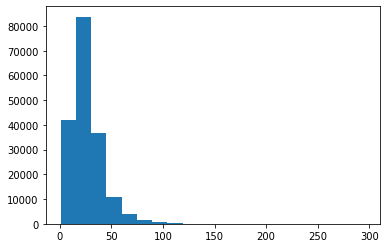

In [ ]:
# what's the distribution looks like?
import matplotlib.pyplot as plt
plt.hist(sent_lens , bins=20);

In [ ]:
# how long  sentence cover 95% of the lenghts?
output_seq_len = int(np.percentile(sent_lens , 95))
output_seq_len

55

In [ ]:
# maximum sentence lenght in the training set
max(sent_lens)

296

### Create Text Vectorization layer

In [ ]:
from tensorflow.keras.layers import TextVectorization
max_tokens  =68000
text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    pad_to_max_tokens=True,
                                    output_sequence_length=output_seq_len)


In [ ]:
# adapt to the train data
text_vectorizer.adapt(train_sentences)

In [ ]:
text_vectorizer(["fahad is a good boy"])

<tf.Tensor: shape=(1, 55), dtype=int64, numpy=
array([[  1,  20,   8, 745,   1,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0]])>

In [ ]:
import random 
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text:{len(target_sentence.split())}")
print(f"\nVectorized Text:{text_vectorizer([target_sentence])}")

Text:
each group underwent dynamic liver mr imaging using a @-t scanner after an intravenous injection of gadoxetic acid at rates of either @ ml/s ( n = @ ) or @ ml/s ( n = @ ) .

Length of text:38

Vectorized Text:[[  122    13   352  1909   604  2078   688    59     8   206  7018    21
     26   511   390     4 14016   386    15   162     4   132  4878    40
     16  4878    40     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [ ]:
# how many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab : {len(rct_20k_text_vocab)} ")
print(f"Most Common Words in the vocab:{rct_20k_text_vocab[:5]}")
print(f"Least Common Words in the vocab:{rct_20k_text_vocab[-5:]}")

Number of words in vocab : 64841 
Most Common Words in the vocab:['', '[UNK]', 'the', 'and', 'of']
Least Common Words in the vocab:['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': True,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True}

### Embedding layer

In [ ]:
from tensorflow.keras.layers import Embedding
embedding = Embedding(input_dim=len(rct_20k_text_vocab),
                      output_dim=128,
                      mask_zero=True)

In [ ]:
print(f"Sentence before Vectorization:\n{target_sentence}")
vectorized_sentence =text_vectorizer([target_sentence])
print(f"\nSentence after Vectorixation:\n{vectorized_sentence}")
embedded_sentene = embedding(vectorized_sentence)  
print(f"\nSentence after embedding :\n{embedded_sentene}")
print(f"\nShape of embedded sentence:{embedded_sentene.shape}")

Sentence before Vectorization:
each group underwent dynamic liver mr imaging using a @-t scanner after an intravenous injection of gadoxetic acid at rates of either @ ml/s ( n = @ ) or @ ml/s ( n = @ ) .

Sentence after Vectorixation:
[[  122    13   352  1909   604  2078   688    59     8   206  7018    21
     26   511   390     4 14016   386    15   162     4   132  4878    40
     16  4878    40     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding :
[[[-0.04763117  0.02334573  0.03448809 ...  0.02038277  0.00913355
    0.02340747]
  [ 0.015228   -0.01888244  0.01452998 ...  0.0087934  -0.04799545
   -0.03326748]
  [-0.0129701   0.0280006   0.03121832 ... -0.01884288 -0.00853898
   -0.04852654]
  ...
  [-0.02904441 -0.01160873 -0.00226548 ...  0.01032081  0.00917933
   -0.00428559]
  [-0.02904441 -0.01160873 -0.00226548 ...  0.01032081  0

### Turn Data into Dataset 

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences , train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences , val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences , test_labels_one_hot))
train_dataset 

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [ ]:
train_dataset  = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [ ]:
num_classes

5

In [ ]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = embedding(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# compile
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_1.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 55)                0         
_________________________________________________________________
embedding (Embedding)        (None, 55, 128)           8299648   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 55, 64)            41024     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 325       
Total params: 8,340,997
Trainable params: 8,340,997
Non-trainable params: 0
_________________________________________________

In [ ]:
# fit the model
model_1_history = model_1.fit(train_dataset ,
                              epochs =3 , 
                              steps_per_epoch = int(0.1*len(train_dataset)),
                              validation_data = val_dataset,
                              validation_steps = int(0.1*len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 9s 14ms/step - loss: 0.6567 - accuracy: 0.7667 - val_loss: 0.5980 - val_accuracy: 0.7856
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 0.4921 - accuracy: 0.8285 - val_loss: 0.5917 - val_accuracy: 0.7839
Epoch 3/3
562/562 [==============================] - 8s 14ms/step - loss: 0.4752 - accuracy: 0.8336 - val_loss: 0.5829 - val_accuracy: 0.7909


In [ ]:
model_1.evaluate(val_dataset)

945/945 [==============================] - 4s 5ms/step - loss: 0.5848 - accuracy: 0.7914


[0.5847675204277039, 0.7913742661476135]

In [ ]:
model_1_pred_probs = model_1.predict(val_dataset)
model_1_pred_probs

array([[5.97177505e-01, 9.47669744e-02, 3.76558118e-02, 2.44346246e-01,
        2.60535125e-02],
       [4.10466105e-01, 1.90068662e-01, 1.15980348e-02, 3.80072683e-01,
        7.79461628e-03],
       [7.69366696e-02, 1.36474380e-03, 6.09240727e-04, 9.21077490e-01,
        1.18910320e-05],
       ...,
       [1.70255282e-06, 6.54770192e-05, 2.56705418e-04, 1.51644667e-06,
        9.99674559e-01],
       [5.24898209e-02, 5.81991255e-01, 1.12411544e-01, 5.42407781e-02,
        1.98866680e-01],
       [6.79743662e-02, 8.88758361e-01, 2.38262117e-02, 5.23683010e-03,
        1.42041594e-02]], dtype=float32)

In [ ]:
model_1_pred = tf.argmax(model_1_pred_probs ,axis =1)
model_1_pred

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
model_1_results = calculate_results(val_labels_encoded , 
                                    model_1_pred)
model_1_results

{'accuracy': 79.13742883622402,
 'f1': 0.7896821257058273,
 'precision': 0.7884743454275999,
 'recall': 0.7913742883622402}

## Model_2 : Feature Extraction with pretained toekn embeedings

In [ ]:
import tensorflow_hub  as hub 
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable = False , 
                                        name="universal_sentence_encoder")

In [ ]:
# Test out the embedding on a random sentence
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
adverse events were recorded throughout the study .

Sentence after embedding:
[ 0.05065588  0.07904902  0.02576297 -0.0670723   0.05953039 -0.0009108
  0.040583    0.00536262  0.02744448  0.00445353 -0.00379891  0.03473751
  0.08908388 -0.03221748  0.03675015 -0.03720836 -0.05284023 -0.03198034
 -0.03548372 -0.06311263 -0.04720806  0.02546839 -0.04388556 -0.03046189
 -0.06253104 -0.00842004  0.04363562  0.00588438  0.04708194  0.06750435] (truncated output)...

Length of sentence embedding:
512


In [ ]:
inputs =  layers.Input(shape=[] , dtype = tf.string)
embedded = tf_hub_embedding_layer(inputs)
x = layers.Dense(128 , activation="relu")(embedded)
outputs = layers.Dense(num_classes , activation="softmax")(x)
model_2 = tf.keras.Model(inputs , outputs , name="USE_Feature_Extraction")

# compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_2.summary()

Model: "USE_Feature_Extraction"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
universal_sentence_encoder ( (None, 512)               256797824 
_________________________________________________________________
dense_10 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 645       
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
model_2_hisotry =  model_2.fit(train_dataset ,
                               epochs = 3,
                               steps_per_epoch = int(0.1 * len(train_dataset)),
                               validation_data = val_dataset,
                               validation_steps = int(0.1 *len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 15s 22ms/step - loss: 0.9193 - accuracy: 0.6470 - val_loss: 0.7989 - val_accuracy: 0.6875
Epoch 2/3
562/562 [==============================] - 12s 21ms/step - loss: 0.7720 - accuracy: 0.7001 - val_loss: 0.7582 - val_accuracy: 0.7018
Epoch 3/3
562/562 [==============================] - 12s 21ms/step - loss: 0.7562 - accuracy: 0.7112 - val_loss: 0.7435 - val_accuracy: 0.7124


In [ ]:
# Evaluate on whole dataset 
model_2.evaluate(val_dataset)

945/945 [==============================] - 18s 19ms/step - loss: 0.7453 - accuracy: 0.7132


[0.7453117370605469, 0.7131603360176086]

In [ ]:
# Get the predictions 
model_2_pred_probs =  model_2.predict(val_dataset)
model_2_pred_probs

array([[4.3814903e-01, 3.5936028e-01, 2.2169959e-03, 1.9382314e-01,
        6.4505222e-03],
       [3.4587520e-01, 4.9413490e-01, 3.2552744e-03, 1.5387985e-01,
        2.8547989e-03],
       [2.2737460e-01, 1.4402176e-01, 2.0211732e-02, 5.7025570e-01,
        3.8136188e-02],
       ...,
       [2.2621851e-03, 6.3180933e-03, 5.7786308e-02, 8.1881852e-04,
        9.3281466e-01],
       [4.4731759e-03, 4.3989819e-02, 2.1203765e-01, 1.6219955e-03,
        7.3787737e-01],
       [1.8722484e-01, 2.4440138e-01, 5.0340879e-01, 5.6294543e-03,
        5.9335515e-02]], dtype=float32)

In [ ]:
# convert probs to labels
model_2_pred = tf.argmax(model_2_pred_probs ,axis=1)
model_2_pred

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [ ]:
# Calculate the results 
model_2_results  = calculate_results(val_labels_encoded , 
                                     model_2_pred)
model_2_results

{'accuracy': 71.31603336422614,
 'f1': 0.7102215216280391,
 'precision': 0.7133513863237418,
 'recall': 0.7131603336422614}

In [ ]:
model_1_resutls

{'accuracy': 79.13742883622402,
 'f1': 0.7896821257058273,
 'precision': 0.7884743454275999,
 'recall': 0.7913742883622402}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Model_3 : Conv1D with character Embedding 

In [ ]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [ ]:
random_training_sentence

'adverse events were recorded throughout the study .'

In [ ]:
# Make Function to Split sentecnes into characters
def split_chars(text):
  return " ".join(list(text))

split_chars(random_training_sentence)

'a d v e r s e   e v e n t s   w e r e   r e c o r d e d   t h r o u g h o u t   t h e   s t u d y   .'

In [ ]:
#Split Sequence lvl data into cahracter lvl data spliter 
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [ ]:
# Whats the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

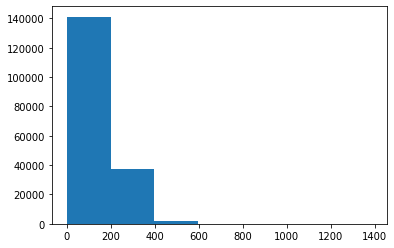

In [ ]:
# Check the distribution of our sequence at a character level 
import matplotlib.pyplot as plt
plt.hist(char_lens , bins=7);

In [ ]:
# find the charcter length covers 95% of sequence 
output_seq_char_len = int(np.percentile(char_lens , 95))
output_seq_char_len

290

In [ ]:
# get all keyboard characters 
import string 
alphabet  = string.ascii_lowercase +  string.digits +string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# creata character lvl token vectorizer instance 
NUM_CHAR_TOKEN = len(alphabet) +2
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKEN,
                                    output_sequence_length = output_seq_char_len,
                                    pad_to_max_tokens=True)
                                    # standardize = None)

In [ ]:
# Adapt character vectorizer to training characters 
char_vectorizer.adapt(train_chars)

In [ ]:
# check character vocab 
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)} ")
print(f"5 most common character in vocab : {char_vocab[:5]}")
print(f"% least common character in vocab : {char_vocab[-5:]}")

Number of different characters in character vocab: 28 
5 most common character in vocab : ['', '[UNK]', 'e', 't', 'i']
% least common character in vocab : ['k', 'x', 'z', 'q', 'j']


In [ ]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
e v a l u a t i o n   w e r e   m a d e   o f   p o s t o p e r a t i v e   p a i n   ,   t r i s m u s   a n d   s w e l l i n g   .

Length of chars: 57

Vectorized chars:
[[ 2 21  5 12 16  5  3  4  7  6 20  2  8  2 15  5 10  2  7 17 14  7  9  3
   7 14  2  8  5  3  4 21  2 14  5  4  6  3  8  4  9 15 16  9  5  6 10  9
  20  2 12 12  4  6 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

In [ ]:
# create character level embedding 
char_embedding = Embedding(input_dim=len(char_vocab),
                           output_dim=25, #char size in the paper 
                           mask_zero =True)

In [ ]:
# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embedding(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
e v a l u a t i o n   w e r e   m a d e   o f   p o s t o p e r a t i v e   p a i n   ,   t r i s m u s   a n d   s w e l l i n g   .

Embedded chars (after vectorization and embedding):
[[[ 0.02488257  0.0148975   0.02859748 ...  0.02664934 -0.00100931
    0.03878803]
  [ 0.03457076  0.00992206  0.04335443 ... -0.00958071  0.03932336
    0.03497804]
  [ 0.01340069  0.01716275 -0.01766441 ...  0.02057615 -0.04107194
   -0.02146359]
  ...
  [-0.01424394 -0.04821927 -0.00381832 ...  0.01963938 -0.03927332
   -0.02983486]
  [-0.01424394 -0.04821927 -0.00381832 ...  0.01963938 -0.03927332
   -0.02983486]
  [-0.01424394 -0.04821927 -0.00381832 ...  0.01963938 -0.03927332
   -0.02983486]]]

Character embedding shape: (1, 290, 25)


In [ ]:
# Make conV1D on char only 
inputs = layers.Input(shape=(1,) , dtype=tf.string)
char_vector = char_vectorizer(inputs)
char_embed = char_embedding(char_vector)
x = layers.Conv1D(64 , 5 , padding="same" , activation="relu")(char_embed)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes , activation="softmax")(x)
model_3 = tf.keras.Model(inputs , outputs)

# Compile the model 
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_3.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_2 (TextVe (None, 290)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 290, 25)           700       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 290, 64)           8064      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 5)                 325       
Total params: 9,089
Trainable params: 9,089
Non-trainable params: 0
_________________________________________________________

In [ ]:
train_chars_dataset = tf.data.Dataset.from_tensor_slices((train_chars , train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_chars_dataset = tf.data.Dataset.from_tensor_slices((val_chars , val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_chars_dataset = tf.data.Dataset.from_tensor_slices((test_chars , test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
train_chars_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [ ]:
model_3_history = model_3.fit(train_chars_dataset,
                              epochs =3,
                              steps_per_epoch = int(0.1 * len(train_chars_dataset)),
                              validation_data = val_chars_dataset,
                              validation_steps=int(0.1*len(val_chars_dataset)))

Epoch 1/3
562/562 [==============================] - 7s 11ms/step - loss: 1.2618 - accuracy: 0.4894 - val_loss: 1.0483 - val_accuracy: 0.5798
Epoch 2/3
562/562 [==============================] - 6s 10ms/step - loss: 1.0132 - accuracy: 0.5900 - val_loss: 0.9496 - val_accuracy: 0.6237
Epoch 3/3
562/562 [==============================] - 5s 10ms/step - loss: 0.9352 - accuracy: 0.6317 - val_loss: 0.8742 - val_accuracy: 0.6662


In [ ]:
model_3.evaluate(val_chars_dataset)

945/945 [==============================] - 5s 5ms/step - loss: 0.8953 - accuracy: 0.6518


[0.8953315615653992, 0.6518270969390869]

In [ ]:
model_3_pred_probs = model_3.predict(val_chars_dataset)
model_3_pred_probs

array([[0.1665784 , 0.35547733, 0.04948567, 0.39271623, 0.03574239],
       [0.22611545, 0.5614992 , 0.01201204, 0.14850295, 0.05187038],
       [0.11887365, 0.34226698, 0.12340716, 0.266389  , 0.14906316],
       ...,
       [0.04181996, 0.04064679, 0.12899758, 0.04645802, 0.74207765],
       [0.03338908, 0.17997476, 0.310432  , 0.04316745, 0.43303677],
       [0.44901425, 0.38922   , 0.04805654, 0.0519683 , 0.06174085]],
      dtype=float32)

In [ ]:
model_3_preds = tf.argmax(model_3_pred_probs , axis=1)
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 1, 1, 2, 2, 2, 2, 1, 4, 3])>

In [ ]:
model_3_results = calculate_results(val_labels_encoded , 
                                    model_3_preds)
model_3_results

{'accuracy': 65.18270885740766,
 'f1': 0.6423097143578445,
 'precision': 0.6494779144142697,
 'recall': 0.6518270885740766}

## Model 4 :Combining pretained token embeddings + character embeddings (hybrid embedding layers)

In [ ]:
# 1.  Setup token inputs/model
token_inputs  =  layers.Input(shape=[] , dtype=tf.string , name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128 , activation="relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs , 
                             token_output)

#2.  Setup char inputs/model
char_inputs = layers.Input(shape=(1,) , dtype=tf.string , name="char_input")
char_vector = char_vectorizer(char_inputs)
char_embed = char_embedding(char_vector)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embed)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

#3. Concatenate token and char  inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                 char_model.output])

# 4. Create output layers
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_Dense = layers.Dense(200 , activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_Dense)
output_layer = layers.Dense(num_classes , activation = "softmax")(final_dropout)

# 5. Construct model with with char and token inputs 
model_4 = tf.keras.Model(inputs=[token_model.input , char_model.input],
                         outputs = output_layer)

In [ ]:
model_4.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_input (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
text_vectorization_2 (TextVecto (None, 290)          0           char_input[0][0]                 
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   token_input[0][0]                
___________________________________________________________________________________________

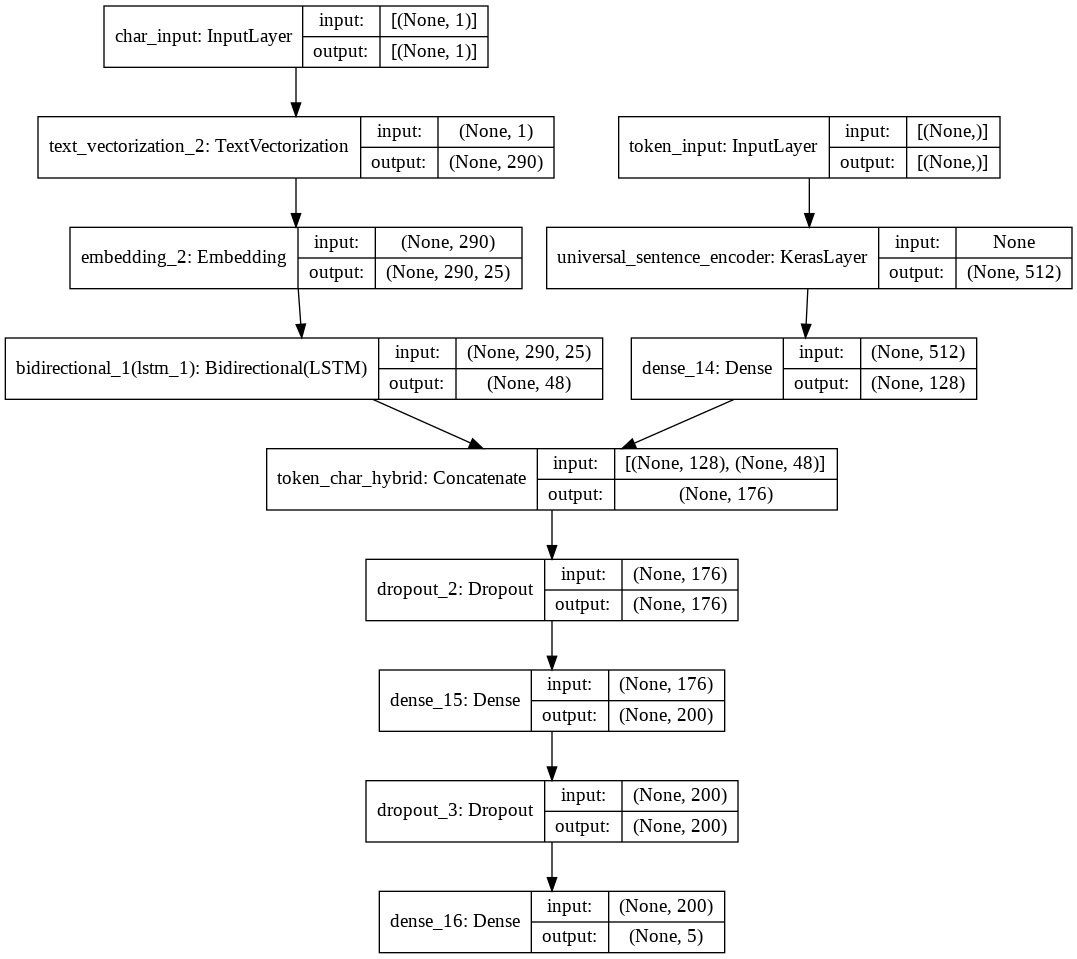

In [ ]:
# Plot hybrid token and character model 
# from keras.utils import plot_model 
tf.keras.utils.plot_model(model_4 , show_shapes=True)

In [ ]:
# Compile the model 
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Combining token and character data into tf.data.Dataset

In [ ]:
# Combine train chars and token into a dataset
trian_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences , train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((trian_char_token_data , train_char_token_labels))

# PRefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Combine val chars and token into a dataset
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences , val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data , val_char_token_labels))

# PRefetch and batch train data
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_char_token_dataset , val_char_token_dataset

(<PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>)

In [ ]:
# Fitting model on token and char level squences 
model_4_history = model_4.fit(train_char_token_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1*len(train_char_token_dataset)),
                              validation_data = val_char_token_dataset,
                              validation_steps=int(0.1*len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 86s 135ms/step - loss: 0.9716 - accuracy: 0.6128 - val_loss: 0.7823 - val_accuracy: 0.7081
Epoch 2/3
562/562 [==============================] - 73s 130ms/step - loss: 0.7914 - accuracy: 0.6946 - val_loss: 0.7106 - val_accuracy: 0.7291
Epoch 3/3
562/562 [==============================] - 69s 123ms/step - loss: 0.7650 - accuracy: 0.7062 - val_loss: 0.6816 - val_accuracy: 0.7447


In [ ]:
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 51s 54ms/step - loss: 0.6880 - accuracy: 0.7395


[0.6879710555076599, 0.7395074963569641]

In [ ]:
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

array([[4.0869334e-01, 3.3429012e-01, 2.7958832e-03, 2.4918900e-01,
        5.0317193e-03],
       [2.9742625e-01, 5.6549376e-01, 2.9941474e-03, 1.3226385e-01,
        1.8219777e-03],
       [2.7650747e-01, 1.1654480e-01, 4.2148013e-02, 5.2917105e-01,
        3.5628628e-02],
       ...,
       [4.9042288e-04, 6.7923483e-03, 3.3565380e-02, 1.8899968e-04,
        9.5896286e-01],
       [5.8252793e-03, 7.2323255e-02, 2.3934467e-01, 2.9262919e-03,
        6.7958051e-01],
       [2.2822648e-01, 3.8116974e-01, 3.1398419e-01, 2.2768009e-02,
        5.3851556e-02]], dtype=float32)

In [ ]:
model_4_preds = tf.argmax(model_4_pred_probs , axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [ ]:
model_4_results  = calculate_results(val_labels_encoded,
                                     model_4_preds)
model_4_results

{'accuracy': 73.95074804713359,
 'f1': 0.7360773371653543,
 'precision': 0.7393663889786982,
 'recall': 0.7395074804713359}

In [ ]:
model_1_resutls

{'accuracy': 79.13742883622402,
 'f1': 0.7896821257058273,
 'precision': 0.7884743454275999,
 'recall': 0.7913742883622402}

## Model 5: Transfer learning with pretained token embedding + character embedding + postional embedding 

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


### Create Positional embedding

In [ ]:
# How many diferent line numbers are there?
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

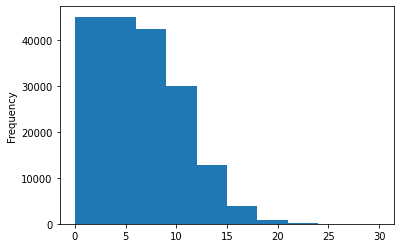

In [ ]:
# Check the distribution of line number column 
train_df.line_number.plot.hist()

In [ ]:
# Use tensoflow to create one hot encoded tensors of our line number column
train_line_number_one_hot =tf.one_hot(train_df["line_number"].to_numpy()  ,depth=15)
val_line_number_one_hot = tf.one_hot(val_df["line_number"].to_numpy() , depth=15)
test_line_number_one_hot = tf.one_hot(test_df["line_number"].to_numpy() , depth=15)
train_line_number_one_hot[:10] , train_line_number_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>, TensorShape([180040, 15]))

### Create positional embedding for total lines

In [ ]:
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

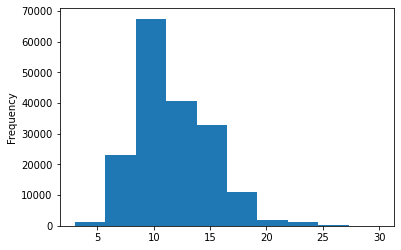

In [ ]:
train_df.total_lines.plot.hist()

In [ ]:
#Now one hot encode the total line numbers
train_total_lines_one_hot  = tf.one_hot(train_df["total_lines"].to_numpy() , depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy() , depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy() , depth= 20)
train_total_lines_one_hot[:20] , train_total_lines_one_hot.shape

(<tf.Tensor: shape=(20, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0

### Building the Trained tribrid model 

In [ ]:
# 1. Token input
token_inputs = layers.Input(shape=[] , dtype=tf.string)
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128 , activation="relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs,
                             token_outputs)

# 2. Char input 
char_inputs = layers.Input(shape=(1,) , dtype=tf.string)
char_vector = char_vectorizer(char_inputs)
char_embed = char_embedding(char_vector)
char_bi_lstm  = layers.Bidirectional(layers.LSTM(32))(char_embed)
char_model = tf.keras.Model(char_inputs,
                            char_bi_lstm)

# 3. Line number input 
line_number_inputs = layers.Input(shape=(15,) , dtype=tf.float32)
x = layers.Dense(32 ,activation="relu")(line_number_inputs)
model_line_number = tf.keras.Model(line_number_inputs,
                                   x)

# 4. Total line input 
total_line_inputs =  layers.Input(shape=(20,) , dtype=tf.float32)
y = layers.Dense(32 , activation="relu")(total_line_inputs)
model_total_line = tf.keras.Model(total_line_inputs,
                                  y)
# 5. combine token and char embeddings into hybrid embedding
combined_embedding = layers.Concatenate(name="token_char_embdding")([token_model.output,
                                                                     char_model.output])
z = layers.Dense(256 , activation="relu")(combined_embedding)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embedding with combined toekn and char embedding
tribrid_embedding = layers.Concatenate(name="positional_combined_embedding")([model_line_number.output,
                                                                              model_total_line.output,
                                                                              z])
# 7. Create ouput layer 
output_layer  = layers.Dense(5 , activation="softmax", name="output_layer")(tribrid_embedding)


# 8. Put together model
model_5 = tf.keras.Model(inputs =[model_line_number.input,
                                  model_total_line.input,
                                  token_model.input,
                                  char_model.input],
                         outputs = output_layer)


In [ ]:
model_5.summary()

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
text_vectorization_2 (TextVecto (None, 290)          0           input_10[0][0]                   
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   input_9[0][0]                    
___________________________________________________________________________________________

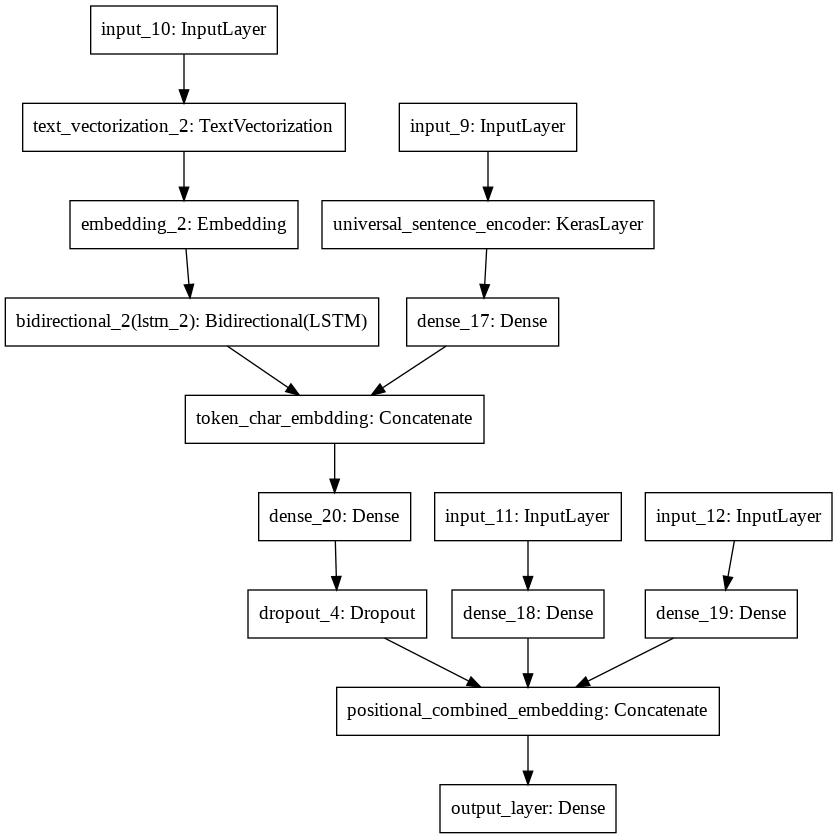

In [ ]:
# from keras.utils import plot_model 
tf.keras.utils.plot_model(model_5)

In [ ]:
# Check which layers are trainable or not 
for layer in model_5.layers:
  print(layer.name , layer.trainable)

input_10 True
input_9 True
text_vectorization_2 True
universal_sentence_encoder False
embedding_2 True
dense_17 True
bidirectional_2 True
token_char_embdding True
input_11 True
input_12 True
dense_20 True
dense_18 True
dense_19 True
dropout_4 True
positional_combined_embedding True
output_layer True


In [ ]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),# add label smoothing(i.e which are really confident get smooth a little)
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# create Dataset for training data
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_number_one_hot , 
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars)) # order of data here is dame as we used in concatenate in our model
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data,
                                                    train_pos_char_token_labels))
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# create Dataset for validation data 
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_number_one_hot , 
                                                                val_total_lines_one_hot,
                                                                val_sentences,
                                                                val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data,
                                                    val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
train_pos_char_token_dataset , val_pos_char_token_dataset

(<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>)

In [ ]:
# Fit the model 
model_5_history =model_5.fit(train_pos_char_token_dataset,
                             epochs=3,
                             steps_per_epoch=int(0.1*len(train_pos_char_token_dataset)),
                             validation_data=val_pos_char_token_dataset,
                             validation_steps=int(0.1*len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 95s 152ms/step - loss: 1.0923 - accuracy: 0.7255 - val_loss: 0.9814 - val_accuracy: 0.8042
Epoch 2/3
562/562 [==============================] - 73s 130ms/step - loss: 0.9655 - accuracy: 0.8163 - val_loss: 0.9476 - val_accuracy: 0.8265
Epoch 3/3
562/562 [==============================] - 68s 121ms/step - loss: 0.9488 - accuracy: 0.8245 - val_loss: 0.9395 - val_accuracy: 0.8314


In [ ]:
model_5.evaluate(val_pos_char_token_dataset)

945/945 [==============================] - 49s 52ms/step - loss: 0.9360 - accuracy: 0.8334


[0.9360367655754089, 0.8334105610847473]

In [ ]:
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset)
model_5_pred_probs

array([[0.52173436, 0.09317511, 0.0133642 , 0.35079578, 0.02093059],
       [0.50828034, 0.10639232, 0.04713991, 0.32655275, 0.01163478],
       [0.26805225, 0.09645902, 0.11323398, 0.4634863 , 0.05876842],
       ...,
       [0.03177733, 0.1049425 , 0.03893488, 0.03288302, 0.79146224],
       [0.02821836, 0.29075187, 0.07721519, 0.02720853, 0.57660604],
       [0.26638398, 0.54448783, 0.09317127, 0.04141835, 0.05453863]],
      dtype=float32)

In [ ]:
model_5_preds = tf.argmax(model_5_pred_probs , axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
model_5_results = calculate_results(val_labels_encoded,
                                    model_5_preds)
model_5_results

{'accuracy': 83.34105653382761,
 'f1': 0.8324830254865646,
 'precision': 0.8323593388328139,
 'recall': 0.8334105653382762}

## Comparing all of our modeling experiment

In [ ]:
# combine all model results in dataframe
all_model_results = pd.DataFrame({"model_0_baseline" : baseline_results,
                                  "model_1_custom_token_embedding":model_1_results,
                                  "model_2_pretained_token_embeddings":model_2_results,
                                  "model_3_custom_char_embed_conv1d": model_3_results,
                                  "model_4_hybrid_char_token_embed": model_4_results,
                                  "model_5-tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,79.137429,0.788474,0.791374,0.789682
model_2_pretained_token_embeddings,71.316033,0.713351,0.713160,0.710222
model_3_custom_char_embed_conv1d,65.182709,0.649478,0.651827,0.642310
model_4_hybrid_char_token_embed,73.950748,0.739366,0.739507,0.736077
model_5-tribrid_pos_char_token_embed,83.341057,0.832359,0.833411,0.832483


In [ ]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

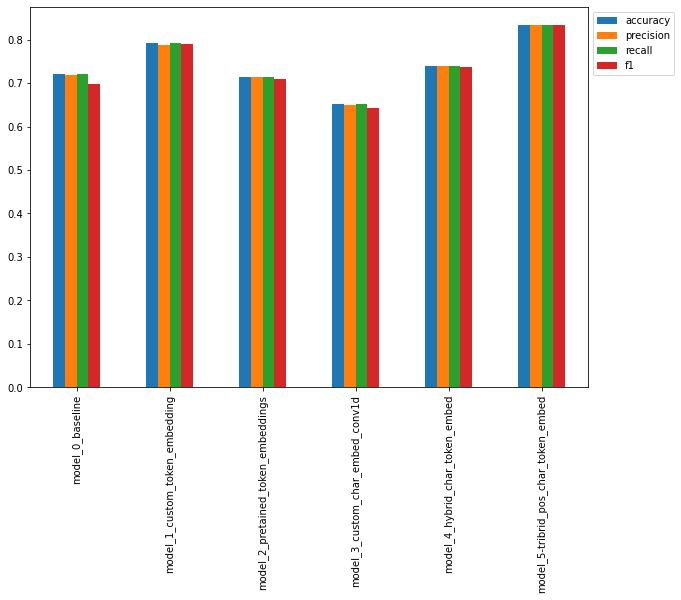

In [ ]:
# plot the reults 
all_model_results.plot(kind="bar" , figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0));

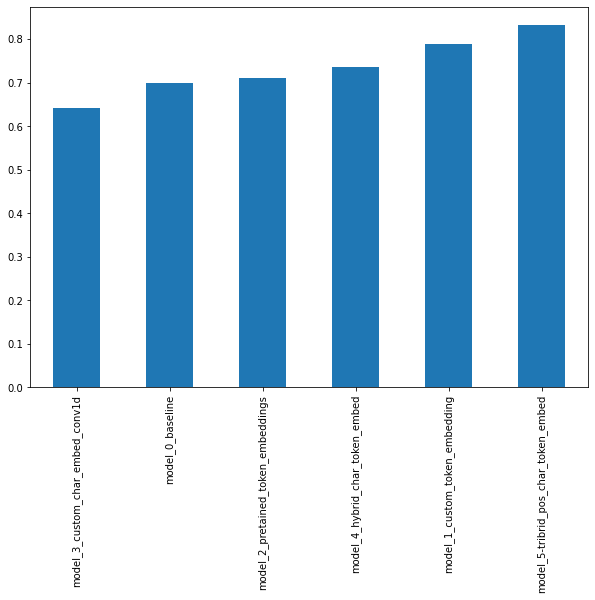

In [ ]:
# Sort the model resuts by F1-score
all_model_results.sort_values("f1" , ascending=True)["f1"].plot(kind="bar" , figsize=(10,7))

## Save and Reload our best model

In [ ]:
model_5.save("model_5_pos_char_token")

INFO:tensorflow:Assets written to: model_5_pos_char_token/assets


INFO:tensorflow:Assets written to: model_5_pos_char_token/assets


In [ ]:
model_5_loaded = tf.keras.models.load_model("model_5_pos_char_token")

ValueError: ignored

## 🤩 Chalange 

### Getting Dataset pubmed-rct

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
import os 
filenames  = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

### Preprocess Data

In [ ]:
def get_lines (filename):
  with open(filename , "r") as f:
    return f.readlines()

In [ ]:
test_lines = get_lines(data_dir + "test.txt")
test_lines[:20]

['###24845963\n',
 'BACKGROUND\tThis study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .\n',
 'RESULTS\tA post hoc analysis was conducted with the use of data from the Evaluation Study of Congestive Heart Failure and Pulmonary Artery Catheterization Effectiveness ( ESCAPE ) .\n',
 'RESULTS\tLiver function tests ( LFTs ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .\n',
 'RESULTS\tSurvival analyses were used to assess the association between admission Model of End-Stage Liver Disease Excluding International Normalized Ratio ( MELD-XI ) scores and patient outcome.There was a high prevalence of abnormal baseline ( admission ) LFTs ( albumin @ % , aspartate transaminase @ % , alanine transaminase @ % , and total bilirubin @ % ) .\n',
 "RESULTS\tThe percentage of patients with abnormal LFTs decreased significantly from baseline to @-months ' follow-up .\n",
 'RE

In [ ]:
def preprocess_text_with_line_numbers(filename):
    input_lines = get_lines(filename) # get all lines from filename
    abstract_lines = "" # create an empty abstract
    abstract_samples = [] # create an empty list of abstracts
    
    # Loop through each line in target file
    for line in input_lines:
      if line.startswith("###"): # check to see if line is an ID line
        abstract_id = line
        abstract_lines = "" # reset abstract string
      elif line.isspace(): # check to see if line is a new line
        abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

        # Iterate through each line in abstract and count them at the same time
        for abstract_line_number, abstract_line in enumerate(abstract_line_split):
          line_data = {} # create empty dict to store data from line
          target_text_split = abstract_line.split("\t") # split target label from text
          line_data["target"] = target_text_split[0] # get target label
          line_data["text"] = target_text_split[1].lower() # get target text and lower it
          line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
          line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
          abstract_samples.append(line_data) # add line data to abstract samples list
      
      else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
        abstract_lines += line
    
    return abstract_samples

In [ ]:
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(test_samples)

30135

In [ ]:
test_samples[:10]

[{'line_number': 0,
  'target': 'BACKGROUND',
  'text': 'this study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( adhf ) .',
  'total_lines': 8},
 {'line_number': 1,
  'target': 'RESULTS',
  'text': 'a post hoc analysis was conducted with the use of data from the evaluation study of congestive heart failure and pulmonary artery catheterization effectiveness ( escape ) .',
  'total_lines': 8},
 {'line_number': 2,
  'target': 'RESULTS',
  'text': 'liver function tests ( lfts ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .',
  'total_lines': 8},
 {'line_number': 3,
  'target': 'RESULTS',
  'text': 'survival analyses were used to assess the association between admission model of end-stage liver disease excluding international normalized ratio ( meld-xi ) scores and patient outcome.there was a high prevalence of abnormal baseline ( admission ) lfts ( albumin @ % , aspart

In [ ]:
import pandas as pd
test_df = pd.DataFrame(test_samples)
test_df.head()

,target,text,line_number,total_lines
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8
1,RESULTS,a post hoc analysis was conducted with the use...,1,8
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8
3,RESULTS,survival analyses were used to assess the asso...,3,8
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8


In [ ]:
test_sentences = test_df["text"].tolist()
test_sentences

['this study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( adhf ) .',
 'a post hoc analysis was conducted with the use of data from the evaluation study of congestive heart failure and pulmonary artery catheterization effectiveness ( escape ) .',
 'liver function tests ( lfts ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .',
 'survival analyses were used to assess the association between admission model of end-stage liver disease excluding international normalized ratio ( meld-xi ) scores and patient outcome.there was a high prevalence of abnormal baseline ( admission ) lfts ( albumin @ % , aspartate transaminase @ % , alanine transaminase @ % , and total bilirubin @ % ) .',
 "the percentage of patients with abnormal lfts decreased significantly from baseline to @-months ' follow-up .",
 'when mean hemodynamic profiles were compared in patients with abnormal versus 

In [ ]:
def split_chars(text):
  return " ".join(list(text))

test_chars = [split_chars(sentence) for sentence in test_sentences]
test_chars[:2]

['t h i s   s t u d y   a n a l y z e d   l i v e r   f u n c t i o n   a b n o r m a l i t i e s   i n   h e a r t   f a i l u r e   p a t i e n t s   a d m i t t e d   w i t h   s e v e r e   a c u t e   d e c o m p e n s a t e d   h e a r t   f a i l u r e   (   a d h f   )   .',
 'a   p o s t   h o c   a n a l y s i s   w a s   c o n d u c t e d   w i t h   t h e   u s e   o f   d a t a   f r o m   t h e   e v a l u a t i o n   s t u d y   o f   c o n g e s t i v e   h e a r t   f a i l u r e   a n d   p u l m o n a r y   a r t e r y   c a t h e t e r i z a t i o n   e f f e c t i v e n e s s   (   e s c a p e   )   .']

### Labels in numeric form 

In [ ]:
# one hot encode labels 
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
test_labels_one_hot = one_hot_encoder.fit_transform(test_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot

array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.]])

In [ ]:
# Get encoded label
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
test_labels_encoded = label_encoder.fit_transform(test_df["target"].to_numpy())
test_labels_encoded

array([0, 4, 4, ..., 4, 4, 1])

### One hot line number and total Lines 

In [ ]:
import tensorflow as tf

In [ ]:
test_line_number_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot[:10]

<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
     

### Download the model

In [ ]:
!wget "https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip"
!mkdir skimlit_gs_model 
!unzip skimlit_tribrid_model.zip -d skimlit_gs_model


--2021-09-30 03:42:41--  https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.120.128, 108.177.121.128, 142.250.128.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.120.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 962561955 (918M) [application/zip]
Saving to: ‘skimlit_tribrid_model.zip’

skimlit_tribrid_mod 100%[===================>] 917.97M   120MB/s    in 7.8s    

2021-09-30 03:42:49 (118 MB/s) - ‘skimlit_tribrid_model.zip’ saved [962561955/962561955]

Archive:  skimlit_tribrid_model.zip
   creating: skimlit_gs_model/skimlit_tribrid_model/
   creating: skimlit_gs_model/skimlit_tribrid_model/variables/
  inflating: skimlit_gs_model/skimlit_tribrid_model/variables/variables.index  
  inflating: skimlit_gs_model/skimlit_tribrid_model/variables/variables.data-00000-of-00001  
  inflating: skimlit_gs_model/skimlit_tribrid_model/kera

### Load the Model 

In [ ]:
import tensorflow as tf 

In [ ]:
laoded_model =  tf.keras.models.load_model("/content/skimlit_gs_model/skimlit_tribrid_model")

### Ready the test dataset 

In [ ]:
test_dataset_data = tf.data.Dataset.from_tensor_slices((test_line_number_one_hot,
                                                   test_total_lines_one_hot,
                                                   test_sentences,
                                                   test_chars)) 
test_dataset_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_dataset = tf.data.Dataset.zip((test_dataset_data,
                                   test_dataset_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset

<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>

### Prediction on test dataset 

In [ ]:
loaded_model_pred_probs =  laoded_model.predict(test_dataset , verbose=1)
loaded_model_preds = tf.argmax(loaded_model_pred_probs ,axis=1)
loaded_model_preds[:10]

942/942 [==============================] - 218s 228ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 3, 2, 2, 4, 4, 4, 1, 4, 0])>

### Getting the helper function

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-09-30 03:47:00--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-09-30 03:47:00 (57.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results

In [ ]:
loaded_model_results = calculate_results(test_labels_encoded,
                                         loaded_model_preds)
loaded_model_results

{'accuracy': 82.39588518334163,
 'f1': 0.8229369808171064,
 'precision': 0.8225726116113812,
 'recall': 0.8239588518334163}

## Most Wrong predictions

In [ ]:
test_pred_classes = [label_encoder.classes_[pred] for pred in loaded_model_preds]
test_pred_classes

['OBJECTIVE',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'RESULTS',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'OBJECTIVE',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'METHODS',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'BACKGROUND',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'RESULTS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 '

In [ ]:
test_df["predictions"] = test_pred_classes
test_df["pred_probs"] = tf.reduce_max(loaded_model_pred_probs , axis=1).numpy()
test_df["correct"] = test_df["predictions"] == test_df["target"]
test_df.head()

,target,text,line_number,total_lines,predictions,pred_probs,correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,OBJECTIVE,0.513077,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,OBJECTIVE,0.310540,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,0.801705,False
3,RESULTS,survival analyses were used to assess the asso...,3,8,METHODS,0.627319,False
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,RESULTS,0.718288,True


In [ ]:
# find the most wrong predictions 
test_df_most_wrong = test_df[test_df["correct"] == False].sort_values("pred_probs" , ascending=False)[:100]
test_df_most_wrong

,target,text,line_number,total_lines,predictions,pred_probs,correct
16347,BACKGROUND,to evaluate the effects of the lactic acid bac...,0,12,OBJECTIVE,0.944838,False
13874,CONCLUSIONS,symptom outcomes will be assessed and estimate...,4,6,METHODS,0.941099,False
1221,RESULTS,data were collected prospectively for @ months...,3,13,METHODS,0.928523,False
13598,METHODS,-@ % vs. fish : -@ % vs. fish + s : -@ % ; p <...,6,9,RESULTS,0.918107,False
21382,OBJECTIVE,"design , settings , participants , and interve...",3,13,METHODS,0.918088,False
...,...,...,...,...,...,...,...
12269,RESULTS,patients received oral se tablets ( @ mcg ) or...,4,10,METHODS,0.821220,False
9881,RESULTS,"the primary outcome was bp control , and secon...",4,11,METHODS,0.821166,False
1220,RESULTS,the group intervention consisted of @ weekly c...,2,13,METHODS,0.821033,False
22105,RESULTS,we randomised @ statin treated cvd patients an...,3,12,METHODS,0.820954,False


In [ ]:
for row in test_df_most_wrong[0:10].itertuples():
  _,target , text , _ , _ , predictions , _ , correct = row 
  print(f"Target: {target} , Pred:{predictions}, correct:{correct}")
  print(f"Text:\n{text}")
  print("\n")


Target: BACKGROUND , Pred:OBJECTIVE, correct:False
Text:
to evaluate the effects of the lactic acid bacterium lactobacillus salivarius on caries risk factors .


Target: CONCLUSIONS , Pred:METHODS, correct:False
Text:
symptom outcomes will be assessed and estimates of cost-effectiveness made .


Target: RESULTS , Pred:METHODS, correct:False
Text:
data were collected prospectively for @ months beginning after completion of the first @ group clinic appointments ( @ months post randomization ) .


Target: METHODS , Pred:RESULTS, correct:False
Text:
-@ % vs. fish : -@ % vs. fish + s : -@ % ; p < @ ) but there were no significant differences between groups .


Target: OBJECTIVE , Pred:METHODS, correct:False
Text:
design , settings , participants , and intervention : ten healthy , normal-weight men were studied in randomized , double-blind fashion , each receiving a @-minute intraduodenal infusion of l-trp at @ ( total @ kcal ) or @ ( total @ kcal ) kcal/min or saline ( control ) .


Target:

### Predcition on sbstracts from pubmed

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

--2021-09-30 03:47:16--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2021-09-30 03:47:16 (57.3 MB/s) - ‘skimlit_example_abstracts.json’ saved [6737/6737]



In [ ]:
import json

In [ ]:
with open("skimlit_example_abstracts.json", "r") as f:
  example_abstracts = json.load(f)

example_abstracts

[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'details': 'RCT of a manualized social treatment for high-functioning autism spectrum 

In [ ]:
import pandas as pd 

In [ ]:
abstracts = pd.DataFrame(example_abstracts)
abstracts

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


In [ ]:
from spacy.lang.en import English
nlp = English()
sentencizer = nlp.create_pipe("sentencizer")
nlp.add_pipe(sentencizer)
doc = nlp(example_abstracts[0]["abstract"])
abstract_lines = [str(sent) for sent in list(doc.sents)]
abstract_lines

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

In [ ]:
# Get total number of lines 
total_lines_in_sample =  len(abstract_lines)

sample_lines = []
for i , line in enumerate(abstract_lines):
  sample_dict = {}
  sample_dict["text"] = str(line)
  sample_dict["line_number"] =  i 
  sample_dict["total_lines"] = total_lines_in_sample -1 
  sample_lines.append(sample_dict)
sample_lines

[{'line_number': 0,
  'text': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
  'total_lines': 7},
 {'line_number': 1,
  'text': 'Participants were randomly assigned to treatment or wait-list conditions.',
  'total_lines': 7},
 {'line_number': 2,
  'text': 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'total_lines': 7},
 {'line_number': 3,
  'text': 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
  'total_lines': 7},
 {'line_number': 4,
  'text': 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
  'total_lines': 7},
 {'line_number': 5,
  'text': 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
  'total_lines': 7},
 {'line_

In [ ]:
test_abstract_line_numbers = [line["line_number"] for line in sample_lines]

test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers , depth=15)
test_abstract_line_numbers_one_hot

<tf.Tensor: shape=(8, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [ ]:
test_abstract_total_lines = [line["total_lines"] for line in sample_lines]

test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines , depth=20)
test_abstract_total_lines_one_hot

<tf.Tensor: shape=(8, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [ ]:
abstract_chars = [split_chars(sentence) for sentence in abstract_lines]
abstract_chars

['T h i s   R C T   e x a m i n e d   t h e   e f f i c a c y   o f   a   m a n u a l i z e d   s o c i a l   i n t e r v e n t i o n   f o r   c h i l d r e n   w i t h   H F A S D s .',
 'P a r t i c i p a n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   t r e a t m e n t   o r   w a i t - l i s t   c o n d i t i o n s .',
 'T r e a t m e n t   i n c l u d e d   i n s t r u c t i o n   a n d   t h e r a p e u t i c   a c t i v i t i e s   t a r g e t i n g   s o c i a l   s k i l l s ,   f a c e - e m o t i o n   r e c o g n i t i o n ,   i n t e r e s t   e x p a n s i o n ,   a n d   i n t e r p r e t a t i o n   o f   n o n - l i t e r a l   l a n g u a g e .',
 'A   r e s p o n s e - c o s t   p r o g r a m   w a s   a p p l i e d   t o   r e d u c e   p r o b l e m   b e h a v i o r s   a n d   f o s t e r   s k i l l s   a c q u i s i t i o n .',
 'S i g n i f i c a n t   t r e a t m e n t   e f f e c t s   w e r e   f o u n d   f o r   f i v e   o f   s e v e n   p 

In [ ]:
test_abstract_pred_probs = laoded_model.predict(x=(test_abstract_line_numbers_one_hot,
                                                   test_abstract_total_lines_one_hot,
                                                   tf.constant(abstract_lines),
                                                   tf.constant(abstract_chars)))
test_abstract_pred_probs

array([[0.24005976, 0.12260363, 0.02247092, 0.5798752 , 0.03499051],
       [0.0561749 , 0.02073206, 0.7538853 , 0.07419971, 0.09500794],
       [0.12344754, 0.06010273, 0.45917472, 0.25462553, 0.10264943],
       [0.0825512 , 0.1425763 , 0.55142474, 0.07865826, 0.1447895 ],
       [0.06460241, 0.12367388, 0.36028856, 0.05729884, 0.39413628],
       [0.03061721, 0.12271819, 0.5668775 , 0.04398259, 0.23580454],
       [0.02591554, 0.1757308 , 0.06679527, 0.02152464, 0.7100338 ],
       [0.02250944, 0.14622352, 0.1988433 , 0.0315266 , 0.60089713]],
      dtype=float32)

In [ ]:
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
test_abstract_preds

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([3, 2, 2, 2, 4, 2, 4, 4])>

In [ ]:
test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]
test_abstract_pred_classes

['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'RESULTS']

In [ ]:
for i, line in enumerate(abstract_lines):
  print(f"{test_abstract_pred_classes[i]}: {line}")

OBJECTIVE: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS: Participants were randomly assigned to treatment or wait-list conditions.
METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
RESULTS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
METHODS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
RESULTS: Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.


## Lets create the function for skimlit to give label to abstract 

1. We need to abstract into array form that is abstract lines 
2. we need to create the dictionary of absrtact lines 
3. we need to one hot the line number 
4. we need to one hot total lines
5. Convert abstract lins to abstract chars 
6. create inputs in the same order in which model is trained
7. Predict on the model return redicted classes 
8. Finally, output the skimed abstract

### get_abstract_lines Function

In [ ]:
def get_abstract_lines(abstract):
  from spacy.lang.en import English
  nlp = English()
  sentencizer = nlp.create_pipe("sentencizer")
  nlp.add_pipe(sentencizer)
  doc = nlp(abstract)
  abstract_lines = [str(sent) for sent in list(doc.sents)]
  return abstract_lines

### create_dict function 

In [ ]:
ab = example_abstracts[0]["abstract"]
abstract_lines = get_abstract_lines(ab)
abstract_lines

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

In [ ]:
def create_dict(abstract_lines):
  total_lines_in_sample =  len(abstract_lines)

  sample_lines = []
  for i , line in enumerate(abstract_lines):
    sample_dict = {}
    sample_dict["text"] = str(line)
    sample_dict["line_number"] =  i 
    sample_dict["total_lines"] = total_lines_in_sample -1 
    sample_lines.append(sample_dict)
  return sample_lines

In [ ]:
sample_lines = create_dict(abstract_lines)
sample_lines

[{'line_number': 0,
  'text': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
  'total_lines': 7},
 {'line_number': 1,
  'text': 'Participants were randomly assigned to treatment or wait-list conditions.',
  'total_lines': 7},
 {'line_number': 2,
  'text': 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'total_lines': 7},
 {'line_number': 3,
  'text': 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
  'total_lines': 7},
 {'line_number': 4,
  'text': 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
  'total_lines': 7},
 {'line_number': 5,
  'text': 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
  'total_lines': 7},
 {'line_

### create_line_number_one_hot Function

In [ ]:
def create_line_number_one_hot(sample_lines):
  test_abstract_line_numbers = [line["line_number"] for line in sample_lines]

  test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers , depth=15)
  return test_abstract_line_numbers_one_hot

In [ ]:
line_number_one_hot = create_line_number_one_hot(sample_lines)
line_number_one_hot

<tf.Tensor: shape=(8, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

### create_total_lines_one_hot function

In [ ]:
def create_total_lines_one_hot(sample_lines):
  test_abstract_total_lines = [line["total_lines"] for line in sample_lines]

  test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines , depth=20)
  return test_abstract_total_lines_one_hot

In [ ]:
total_lines_one_hot = create_total_lines_one_hot(sample_lines)
total_lines_one_hot

<tf.Tensor: shape=(8, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

### create_abstract_char fucntion

In [ ]:
def create_abstract_char(abstract_lines):
  abstract_chars = [split_chars(sentence) for sentence in abstract_lines]
  return abstract_chars

In [ ]:
abstract_chars = create_abstract_char(abstract_lines)
abstract_chars

['T h i s   R C T   e x a m i n e d   t h e   e f f i c a c y   o f   a   m a n u a l i z e d   s o c i a l   i n t e r v e n t i o n   f o r   c h i l d r e n   w i t h   H F A S D s .',
 'P a r t i c i p a n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   t r e a t m e n t   o r   w a i t - l i s t   c o n d i t i o n s .',
 'T r e a t m e n t   i n c l u d e d   i n s t r u c t i o n   a n d   t h e r a p e u t i c   a c t i v i t i e s   t a r g e t i n g   s o c i a l   s k i l l s ,   f a c e - e m o t i o n   r e c o g n i t i o n ,   i n t e r e s t   e x p a n s i o n ,   a n d   i n t e r p r e t a t i o n   o f   n o n - l i t e r a l   l a n g u a g e .',
 'A   r e s p o n s e - c o s t   p r o g r a m   w a s   a p p l i e d   t o   r e d u c e   p r o b l e m   b e h a v i o r s   a n d   f o s t e r   s k i l l s   a c q u i s i t i o n .',
 'S i g n i f i c a n t   t r e a t m e n t   e f f e c t s   w e r e   f o u n d   f o r   f i v e   o f   s e v e n   p 

### input_for_model function

In [ ]:
def input_for_model(line_number_one_hot , total_lines_one_hot, abstract_lines ,abstract_chars):
  input=(line_number_one_hot,
     total_lines_one_hot,
     tf.constant(abstract_lines),
     tf.constant(abstract_chars))
  return input

In [ ]:
input=input_for_model(line_number_one_hot , total_lines_one_hot, abstract_lines ,abstract_chars)
input

(<tf.Tensor: shape=(8, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],
       dtype=float32)>, <tf.Tensor: shape=(8, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0.

### predict_classes function

In [ ]:
def predict_classes(model , input , label_encoder):
  from sklearn.preprocessing import LabelEncoder
  label_encoder = LabelEncoder()
  test_abstract_pred_probs = model.predict(x=input)
  test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
  test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]
  return test_abstract_pred_classes 

In [ ]:
predict_classes = predict_classes(laoded_model , input , label_encoder)
predict_classes

### output function

In [ ]:
def output(abstract_lines , predict_classes):
  for i, line in enumerate(abstract_lines):
    print(f"{predict_classes[i]}: {line}")

In [ ]:
output(abstract_lines , predict_classes)

### SkimLit Function

In [ ]:
def SkimLit(model , abstract):
  abstract_lines = get_abstract_lines(abstract)
  sample_lines = create_dict(abstract_lines)
  line_number_one_hot = create_line_number_one_hot(sample_lines)
  total_lines_one_hot = create_total_lines_one_hot(sample_lines)
  abstract_chars = create_abstract_char(abstract_lines)
  input=input_for_model(line_number_one_hot , total_lines_one_hot, abstract_lines ,abstract_chars)
  predict_class = predict_classes(model , input)
  output(abstract_lines , predict_classes)

In [ ]:
abstract =example_abstracts[1]["abstract"]
a = SkimLit(laoded_model , abstract)
a

In [ ]:
label_encoder.classes_